---
---

### Solution of 1D Ornstein–Uhlenbeck process

Ornstein–Uhlenbeck process
$$
    \frac{d \, x}{d \, t} = - \lambda x(t) + w(t),
    \quad
    x(0) = x_0,
    \quad
    \lambda > 0,
$$
or
$$
    d \, x = - \lambda x(t) d \, t + d \, \beta(t),
    \quad
    x(0) = x_0,
    \quad
    \lambda > 0,
$$

Its solution is
$$
    x(t) = e^{-\lambda t} x(0) + \int_0^t e^{-\lambda (t - \tau)} d \, \beta(\tau),
$$
and covariance matrix is
$$
    C(t) = \frac{q}{2\lambda} e^{-\lambda |t|},
$$
where $q$ is spectral density of the one dimensional white noise process $w(t)$.

The probability density function (PDF) $\rho(x, t)$ satisfies the Fokker–Planck equation
$$
   \frac{\partial \, \rho}{\partial \, t} =
       \lambda \frac{\partial}{\partial \, x} (x \rho) +
       \frac{1}{2} \frac{\partial^2 \, \rho}{\partial \, x^2},
$$
with transition probability
$$
    \rho(x, t) = 
        \sqrt{
            \frac{\lambda}{\pi \left( 1 - e^{-2 \lambda t} \right)}
        }
        e^{\frac
            {-\lambda \left( x - x_0 e^{-\lambda t} \right)^2}
            {1 - e^{-2 \lambda t}}
        }.
$$

In [1]:
import sys
import time

import numpy as np
from numpy import kron as kron

import scipy.sparse as sp
from scipy.linalg import expm as expm
from scipy.interpolate import RectBivariateSpline

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import animation, rc

from IPython.display import HTML

sys.path.append('./../lib')
from intertrain import Intertrain

In [11]:
# SDE parameters : f = A x, df / dx = A (dimension = 1)

A = -1.

def func_f(x):
    return A*x

def func_f_der(x):
    if not isinstance(x, np.ndarray):
        return A
    return A*np.ones(x.shape)

def func_r0(x):
    s = 1.
    m = 0.
    r = 1./np.sqrt(2.*np.pi * s**2)
    r*= np.exp(-1. * (x-m)**2 / 2. / s**2)
    return r.reshape(-1)
    # return np.exp(-0.5 * np.diag(x.T@x))

def func_r_trans(x, t, x0):
    l = -1. * A
    e = np.exp(-1. * l * t)
    r = np.sqrt(l / np.pi /  (1. - e*e))
    r*= np.exp(-1. * l * (x - x0 * e)**2 / (1. - e*e))
    return r

In [12]:
# Time grid

t_min = 0.
t_max = 1.
t_poi = 10 # including t_min and t_max (>= 2)

m = t_poi
h = (t_max - t_min) / (t_poi - 1)

T = np.linspace(0., 1., 10)

In [13]:
# Spatial grid

n = 40
IT = Intertrain(n=[n], l=[[-3., 3.]], with_tt=False)
X = IT.grid()

In [14]:
# Special matrices

I = np.eye(n)
D = IT.dif1()
# D = D[1:-1, 1:-1] # for BC
Z = expm(D)
Z = np.exp(h) * Z # kron(Z, Z)

In [15]:
def interpolate(r0, x):
    return IT.init(Y=r0).prep().calc(x)

In [20]:
def step(x0, r0):
    f = func_f(x0)
    g = func_f_der(x0)
    
    x = x0 + h * f
    r = (1. - h * np.trace(g)) * Z@interpolate(r0, X - h * f)

    return (x, r)

In [21]:
def calc():
    
    # Initial condition
    x = X.copy()
    r = func_r0(x)

    X_list = [x]
    R_list = [r]
    
    for _ in range(t_poi-1):
        x, r = step(x, r)
        X_list.append(x)
        R_list.append(r)
    
    return (X_list, R_list)

In [22]:
# Run caclulations

X_list, R_list = calc()

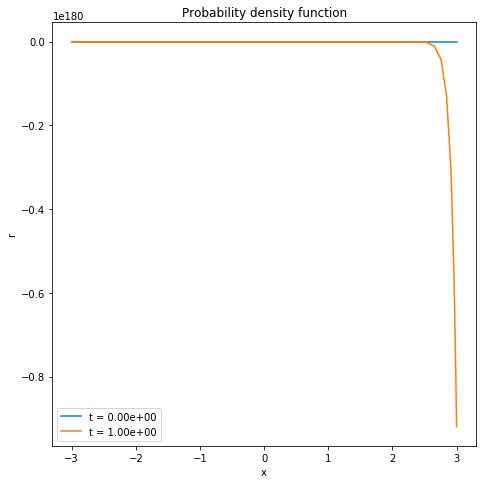

In [23]:
# Plot distribution (initial and final) on the spatial grid

fig = plt.figure(figsize=(6, 6))
gs = mpl.gridspec.GridSpec(
    ncols=1, nrows=1, left=0.01, right=0.99, top=0.99, bottom=0.01,
    wspace=0.4, hspace=0.3, width_ratios=[1], height_ratios=[1]
)

r1 = R_list[0].reshape(-1)
r2 = R_list[-1].reshape(-1)
ax = fig.add_subplot(gs[0, 0])
ax.plot(X.reshape(-1), r1, label='t = %-8.2e'%t_min)
ax.plot(X.reshape(-1), r2, label='t = %-8.2e'%t_max)
ax.set_title('Probability density function')
ax.set_xlabel('x')
ax.set_ylabel('r')
ax.legend(loc='best')

plt.show()